<a href="https://colab.research.google.com/github/N-k-Siam/210113_CNN_Vehicles_-_Animals_CIFAR-10/blob/main/210113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone GitHub Repo

In [1]:
!git clone https://github.com/N-k-Siam/210113_CNN_Vehicles_-_Animals_CIFAR-10.git

Cloning into '210113_CNN_Vehicles_-_Animals_CIFAR-10'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 128 (delta 50), reused 43 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 11.89 MiB | 30.66 MiB/s, done.
Resolving deltas: 100% (50/50), done.


#Load Custom Image Paths from Repo

In [2]:
import glob, random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

repo_dir = "210113_CNN_Vehicles_-_Animals_CIFAR-10"
custom_paths = sorted(glob.glob(f"{repo_dir}/dataset/*"))
print("Custom images found:", len(custom_paths))
custom_paths[:10]

Device: cpu
Custom images found: 10


['210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/bird1.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/bird2.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/car1.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/car2.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/cat1.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/cat2.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/cat3.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/dog1.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/dog2.jpg',
 '210113_CNN_Vehicles_-_Animals_CIFAR-10/dataset/dog3.jpg']

#Define Classes

In [3]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

#Resize image


In [4]:
from torchvision import transforms


cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])
transform


Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

#Download CIFAR-10

In [5]:
from torchvision import datasets

full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_ds    = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 62.6MB/s]


#Train, Val, Test Data Split

In [6]:
from torch.utils.data import DataLoader, random_split


train_size = int(0.9 * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


Train: 45000 Val: 5000 Test: 10000


# Build CNN Model

In [7]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CNN().to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss/total, correct/total


# Train CNN

In [9]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = -1.0
best_state = None

for ep in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep}/{epochs} | Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | Val loss={va_loss:.4f}, acc={va_acc:.4f}")



Epoch 1/10 | Train loss=1.4306, acc=0.4792 | Val loss=1.1085, acc=0.5956
Epoch 2/10 | Train loss=1.0077, acc=0.6428 | Val loss=0.8827, acc=0.6870
Epoch 3/10 | Train loss=0.8386, acc=0.7045 | Val loss=0.8156, acc=0.7148
Epoch 4/10 | Train loss=0.7162, acc=0.7489 | Val loss=0.7539, acc=0.7350
Epoch 5/10 | Train loss=0.6225, acc=0.7805 | Val loss=0.7380, acc=0.7418
Epoch 6/10 | Train loss=0.5576, acc=0.8042 | Val loss=0.7646, acc=0.7430
Epoch 7/10 | Train loss=0.4828, acc=0.8289 | Val loss=0.7666, acc=0.7486
Epoch 8/10 | Train loss=0.4248, acc=0.8466 | Val loss=0.7717, acc=0.7542
Epoch 9/10 | Train loss=0.3719, acc=0.8661 | Val loss=0.8016, acc=0.7432
Epoch 10/10 | Train loss=0.3329, acc=0.8799 | Val loss=0.7982, acc=0.7548


#Plot Loss & Accuracy Curves

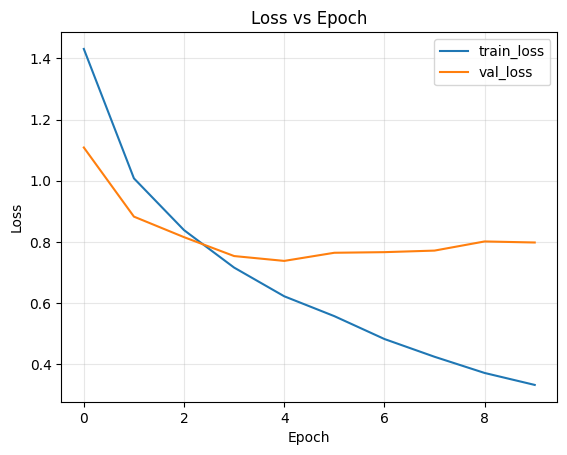

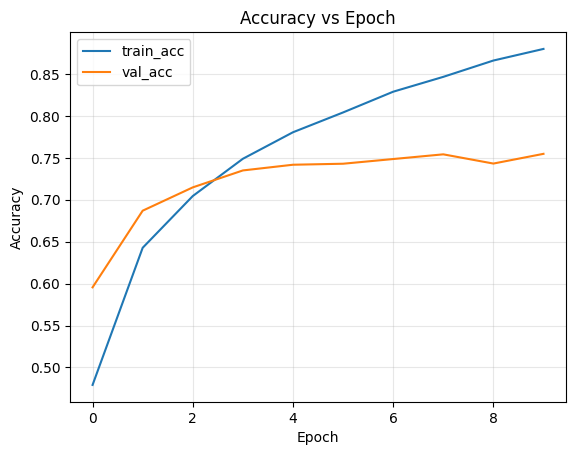

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.plot(train_accs, label="train_acc")
plt.plot(val_accs, label="val_acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


#Test Set Prediction

In [11]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())

print("Done:", len(y_true), len(y_pred))


Done: 10000 10000


#Confusion Matrix

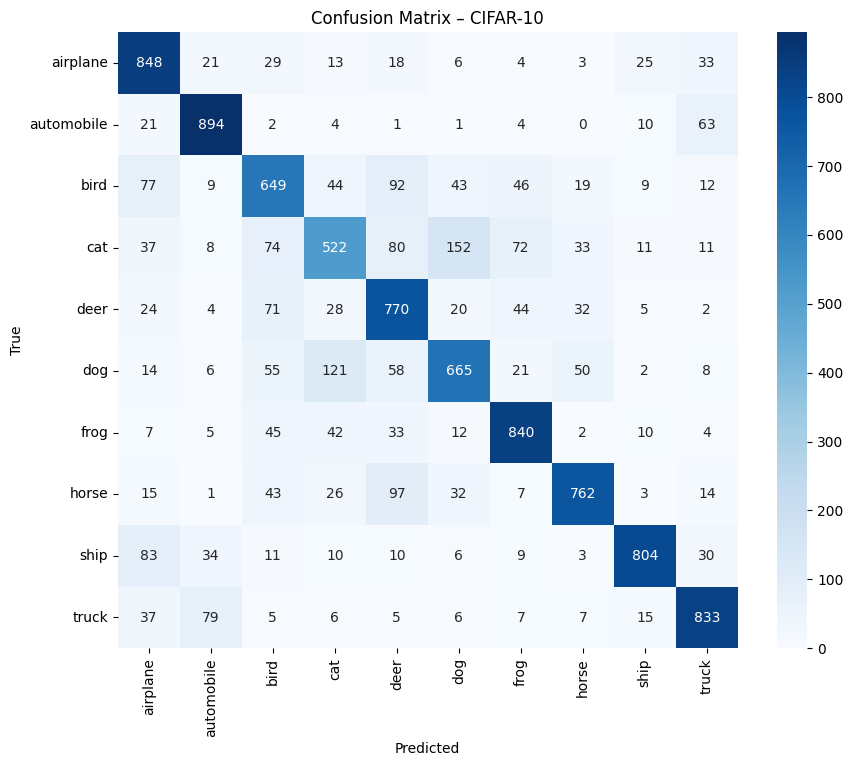

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix – CIFAR-10")
plt.show()


#Save Trained Model Weights

In [13]:
import os, torch

os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/210113.pth")

!ls -lah model

total 2.4M
drwxr-xr-x 2 root root 4.0K Dec 25 18:30 .
drwxr-xr-x 1 root root 4.0K Dec 25 18:30 ..
-rw-r--r-- 1 root root 2.4M Dec 25 18:30 210113.pth


#Predict on Custom Images

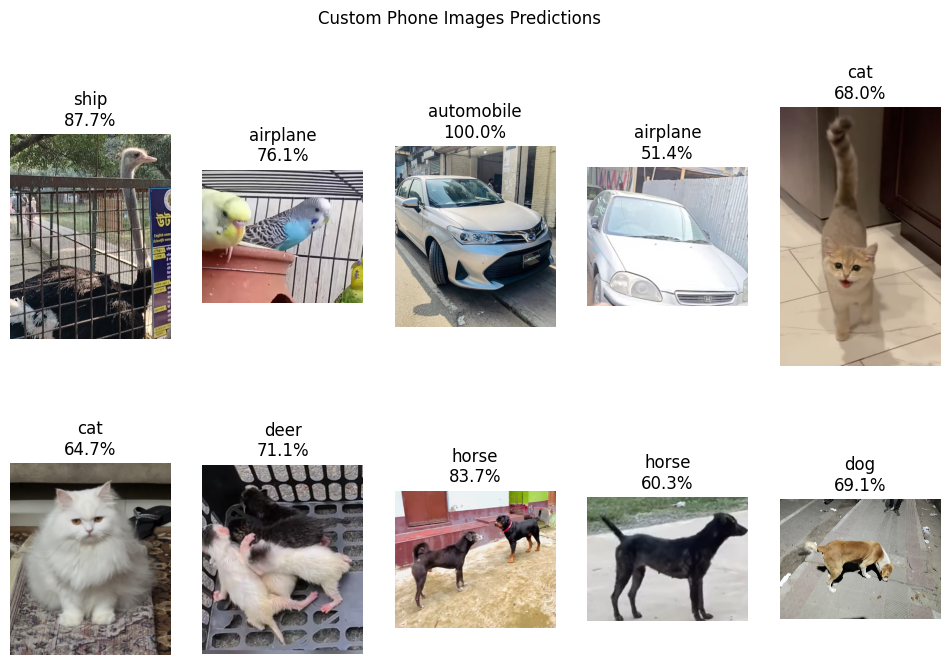

In [18]:
from PIL import Image



def predict_one(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0]
        pred = prob.argmax().item()
        conf = prob[pred].item() * 100
    return pred, conf, img

plt.figure(figsize=(12,8))
show_paths = custom_paths[:10]

for i, p in enumerate(show_paths):
    pred, conf, img = predict_one(p)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{classes[pred]}\n{conf:.1f}%")

plt.suptitle("Custom Phone Images Predictions")
# plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.subplots_adjust(hspace=0.1, top=0.88)
plt.show()


#Visual Error Analysis

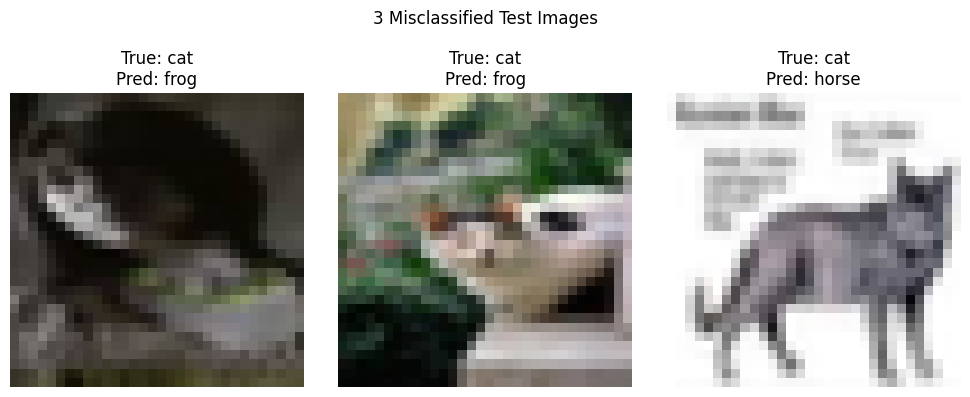

In [15]:
import numpy as np


y_true = np.array(y_true)
y_pred = np.array(y_pred)

wrong_idx = np.where(y_pred != y_true)[0]
np.random.shuffle(wrong_idx)
pick = wrong_idx[:3]

mean = torch.tensor(cifar_mean).view(3,1,1)
std  = torch.tensor(cifar_std).view(3,1,1)

def denorm(img_t):

    x = img_t.clone()
    x = x * std + mean
    return x.clamp(0, 1)

plt.figure(figsize=(10,4))
for i, idx in enumerate(pick):
    img_t, _ = test_ds[idx]
    img = denorm(img_t).permute(1,2,0).numpy()

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")

plt.suptitle("3 Misclassified Test Images")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
